In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

from dataset.transformers_dataset import load_data
from metrics.auc import k_fold_roc_curve, godbole_accuracy

Data loading

In [2]:
sns.set_theme("notebook", "whitegrid")

In [5]:
df = load_data("multi_label_dataset.csv", "articles", False)

In [6]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
X = vectorizer.fit_transform(df["Text"])
vectorizer.get_feature_names_out()

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['0', '00', '000', ..., 'à', '白鹿视频', '陳奕迅'], dtype=object)

In [12]:
X.shape

(110, 8915)

In [16]:
y = df[df.columns[2:-1]].to_numpy()

In [17]:
y

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1,

Multilabel Classification

In [49]:
from typing import Callable
from functools import partial

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, coverage_error, f1_score,
                             label_ranking_average_precision_score,
                             label_ranking_loss, multilabel_confusion_matrix,
                             precision_score, recall_score, roc_auc_score)
from sklearn.neighbors import KNeighborsClassifier

In [51]:
%load_ext autoreload

In [9]:
NUM_FOLDS = 5

In [10]:
mskf = MultilabelStratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

In [47]:
def train_and_eval(
    mskf: MultilabelStratifiedKFold, model_class: Callable, X: np.ndarray, y: np.ndarray
) -> dict[str, float]:
    """Train and evaluate a model using MultilabelStratifiedKFold cross-validation.

    Args:
        mskf (MultilabelStratifiedKFold): MultilabelStratifiedKFold object
        model_class (Callable): Class of the model to be trained
        X (np.ndarray): Dataset of input features
        y (np.ndarray): Dataset of target labels

    Returns:
        dict[str, float]: Dictionary of metrics
    """
    print(f"Model type: {model_class.__name__}")

    # Initialize lists to store metrics
    accs, lraps, f1s, lrls, precs, recs, cov_errs, aurocs, godbole_accs = (
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    )
    y_preds, y_probs, y_tests = [], [], []

    for i, (train_idx, test_idx) in enumerate(mskf.split(X, y)):
        # Split the dataset into training and testing sets
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize and fit the model to training data
        model = model_class()
        model.fit(X_train, y_train)

        # Retrieve the predicted probabilities and labels
        y_prob = np.array(model.predict_proba(X_test))
        if not model_class.__name__ == "MLPClassifier":
            y_prob = y_prob[:, :, 1].reshape(len(y_test), -1)
        y_pred = model.predict(X_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        godbole_acc = godbole_accuracy(y_test, y_pred, "macro")
        godbole_chance_acc = godbole_accuracy(y_test, np.ones_like(y_test), "macro")
        cov_error = coverage_error(y_test, y_prob)
        f1 = f1_score(y_test, y_pred, average="micro")
        lrap = label_ranking_average_precision_score(y_test, y_prob)
        lrl = label_ranking_loss(y_test, y_prob)
        prec = precision_score(y_test, y_pred, average="micro")
        rec = recall_score(y_test, y_pred, average="micro")
        ap_chance_level = y_test.sum() / y_test.size # Chance level for AP
        mlm = multilabel_confusion_matrix(y_test, y_pred)
        auroc = roc_auc_score(y_test, y_prob, average="micro")

        # Append metrics to lists
        accs.append(acc)
        godbole_accs.append(godbole_acc)
        lraps.append(lrap)
        f1s.append(f1)
        lrls.append(lrl)
        precs.append(prec)
        recs.append(rec)
        cov_errs.append(cov_error)
        y_preds.append(y_pred)
        y_probs.append(y_prob)
        y_tests.append(y_test)
        aurocs.append(auroc)

        # Print metrics
        print(f"Fold: {i + 1}")
        print(
            f"acc: {acc:.4f}",
            f"godbole_acc: {godbole_acc:.4f} / {godbole_chance_acc:.4f} (chance)",
            f"lrap: {lrap:.4f} / {ap_chance_level:.4f} (chance)",
            f"f1: {f1:.4f}",
            f"lrl: {lrl:.4f}",
            f"prec: {prec:.4f}",
            f"rec: {rec:.4f}",
            f"cov_err: {cov_error:.4f}",
            f"auroc: {auroc:.4f}",
            sep="\n",
            end="\n\n",
        )

    # Return metrics as a dictionary
    return {
        "acc": accs,
        "godbole_accs": godbole_accs,
        "lrap": lraps,
        "f1": f1s,
        "lrl": lrls,
        "prec": precs,
        "rec": recs,
        "cov_err": cov_errs,
        "y_pred": y_preds,
        "y": y_tests,
        "y_prob": y_probs,
        "auroc": aurocs,
        "mlm": mlm,
    }

In [48]:
results = {}
for model in [RandomForestClassifier, KNeighborsClassifier, DecisionTreeClassifier, MLPClassifier]:
    res = train_and_eval(mskf, model, X, y)
    results[model.__name__]= res

for model, res in results.items():
    print("\n")
    print("=" * 80)
    print(f"model: {model}")
    print(
        f"acc: {np.mean(res['acc']):.4f} +/- {np.std(res['acc']):.4f}",
        f"godbole_acc: {np.mean(res['godbole_accs']):.4f} +/- {np.std(res['godbole_accs']):.4f} / {godbole_accuracy(y, np.ones_like(y), "macro"):.4f} (chance level)",
        f"lrap: {np.mean(res['lrap']):.4f} +/- {np.std(res["lrap"]):.4f} / {y.sum() / y.size:.4f} (chance level)",
        f"f1: {np.mean(res['f1']):.4f} +/- {np.std(res['f1']):.4f}",
        f"lrl: {np.mean(res['lrl']):.4f} +/- {np.std(res['lrl']):.4f}",
        f"prec: {np.mean(res['prec']):.4f} +/- {np.std(res['prec']):.4f}",
        f"rec: {np.mean(res['rec']):.4f} +/- {np.std(res['rec']):.4f}",
        f"cov_err: {np.mean(res['cov_err']):.4f} +/- {np.std(res['cov_err']):.4f}",
        f"auroc: {np.mean(res['auroc']):.4f} +/- {np.std(res['auroc']):.4f}",
        "=" * 80,
        sep="\n",
        end="\n",
    )

best_model = max(results.items(), key=lambda x: x[1]["f1"])
print(f"Best model: {best_model[0]}, F1: {np.mean(best_model[1]['f1']):.4f}")

Model type: RandomForestClassifier
Fold: 1
acc: 0.7273
godbole_acc: 0.8182 / 0.8352 (chance)
lrap: 0.8490 / 0.8352 (chance)
f1: 0.9000
lrl: 0.1668
prec: 0.8324
rec: 0.9796
cov_err: 7.6364
auroc: 0.6232

Fold: 2
acc: 0.6818
godbole_acc: 0.8428 / 0.8352 (chance)
lrap: 0.8867 / 0.8352 (chance)
f1: 0.9159
lrl: 0.1479
prec: 0.8448
rec: 1.0000
cov_err: 7.7727
auroc: 0.4928

Fold: 3
acc: 0.6818
godbole_acc: 0.8011 / 0.8295 (chance)
lrap: 0.8602 / 0.8295 (chance)
f1: 0.8896
lrl: 0.1758
prec: 0.8246
rec: 0.9658
cov_err: 7.7273
auroc: 0.4920

Fold: 4
acc: 0.6957
godbole_acc: 0.7880 / 0.7880 (chance)
lrap: 0.8855 / 0.7880 (chance)
f1: 0.8815
lrl: 0.1005
prec: 0.7880
rec: 1.0000
cov_err: 7.1739
auroc: 0.5345

Fold: 5
acc: 0.8095
godbole_acc: 0.8869 / 0.8869 (chance)
lrap: 0.9134 / 0.8869 (chance)
f1: 0.9401
lrl: 0.0978
prec: 0.8869
rec: 1.0000
cov_err: 7.8095
auroc: 0.6171

Model type: KNeighborsClassifier
Fold: 1
acc: 0.6364
godbole_acc: 0.8068 / 0.8352 (chance)
lrap: 0.8426 / 0.8352 (chance)
f1:

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 1
acc: 0.7273
godbole_acc: 0.8182 / 0.8352 (chance)
lrap: 0.8963 / 0.8352 (chance)
f1: 0.9000
lrl: 0.1104
prec: 0.8324
rec: 0.9796
cov_err: 7.2273
auroc: 0.6022



c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 2
acc: 0.6364
godbole_acc: 0.7648 / 0.8352 (chance)
lrap: 0.8579 / 0.8352 (chance)
f1: 0.8787
lrl: 0.1538
prec: 0.8481
rec: 0.9116
cov_err: 7.5909
auroc: 0.5466



c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 3
acc: 0.6364
godbole_acc: 0.7784 / 0.8295 (chance)
lrap: 0.8697 / 0.8295 (chance)
f1: 0.8754
lrl: 0.1475
prec: 0.8204
rec: 0.9384
cov_err: 7.5000
auroc: 0.4628



c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 4
acc: 0.6087
godbole_acc: 0.7337 / 0.7880 (chance)
lrap: 0.8394 / 0.7880 (chance)
f1: 0.8517
lrl: 0.1381
prec: 0.7849
rec: 0.9310
cov_err: 7.2174
auroc: 0.5432

Fold: 5
acc: 0.7619
godbole_acc: 0.8750 / 0.8869 (chance)
lrap: 0.9605 / 0.8869 (chance)
f1: 0.9333
lrl: 0.0403
prec: 0.8855
rec: 0.9866
cov_err: 7.4762
auroc: 0.6726



model: RandomForestClassifier
acc: 0.7192 +/- 0.0481
godbole_acc: 0.8274 +/- 0.0349 / 0.8341 (chance level)
lrap: 0.8790 +/- 0.0225 / 0.8341 (chance level)
f1: 0.9054 +/- 0.0208
lrl: 0.1378 +/- 0.0328
prec: 0.8353 +/- 0.0320
rec: 0.9891 +/- 0.0141
cov_err: 7.6240 +/- 0.2324
auroc: 0.5519 +/- 0.0578


model: KNeighborsClassifier
acc: 0.6468 +/- 0.0601
godbole_acc: 0.8126 +/- 0.0427 / 0.8341 (chance level)
lrap: 0.8396 +/- 0.0245 / 0.8341 (chance level)
f1: 0.8970 +/- 0.0273
lrl: 0.2232 +/- 0.0371
prec: 0.8340 +/- 0.0384
rec: 0.9713 +/- 0.0219
cov_err: 7.8118 +/- 0.1585
auroc: 0.4782 +/- 0.0306


model: DecisionTreeClassifier
acc: 0.5195 +/- 0.0781
godbole

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
print(best_model[1].keys())

dict_keys(['acc', 'lrap', 'f1', 'lrl', 'prec', 'rec', 'cov_err', 'y_pred', 'y', 'y_prob', 'auroc', 'mlm'])


In [28]:
best_model_outputs = []
for i in range(NUM_FOLDS):
    results = {
        "y_pred": best_model[1]["y_pred"][i],
        "y_prob": best_model[1]["y_prob"][i],
        "y": best_model[1]["y"][i],
    }
    best_model_outputs.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]

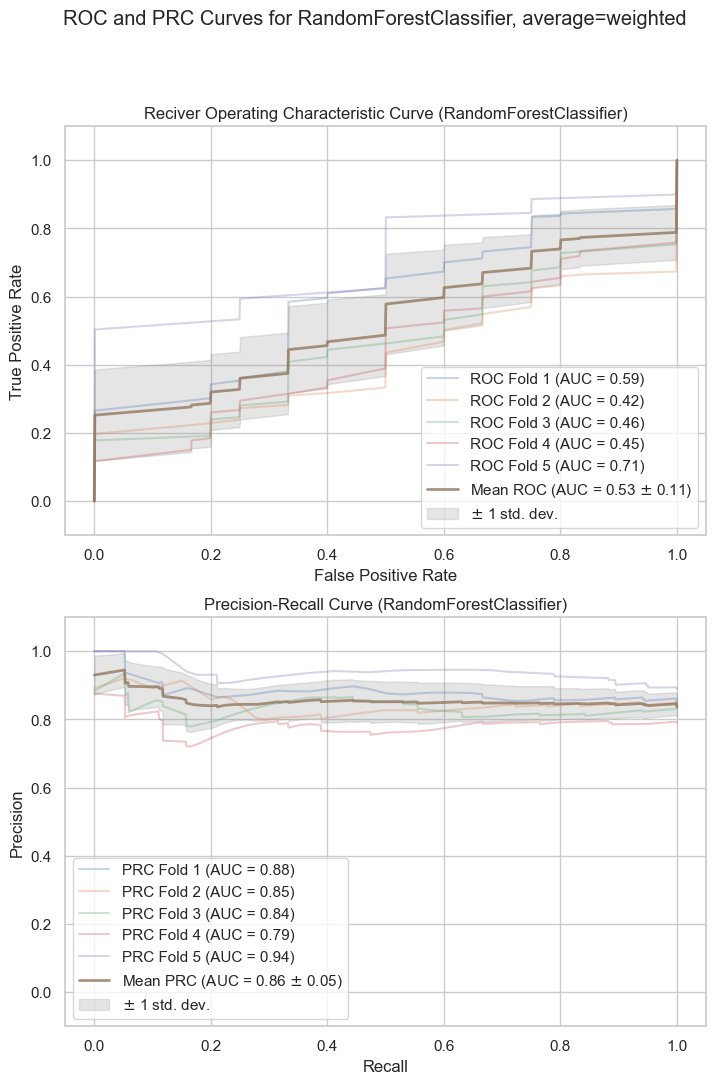

In [30]:
k_fold_roc_curve(
    best_model_outputs,
    best_model[0],
    len(df.columns[2:-1]),
    "weighted",
)

Attention Model

In [77]:
import torch
import torch.nn.functional as F
import scipy
from torch import nn

from models.tfidf_attention import TfIdfAttention

In [75]:
model = TfIdfAttention(X.shape[1], len(df.columns[2:-1]), 768, 12, 0.2)

In [74]:
X.shape

(110, 8915)

In [83]:
def csr_matrix_to_tensor(
    csr: scipy.sparse.csr_matrix, padding: tuple[int, int] = (0, 0)
) -> torch.Tensor:
    coo = csr.tocoo()
    values = coo.data
    indices = np.vstack((coo.row + padding[0], coo.col + padding[1]))
    shape = [coo.shape[0] + padding[0], coo.shape[1] + padding[1]]

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)

    return torch.sparse_coo_tensor(i, v, torch.Size(shape))

In [86]:
X_tensor = csr_matrix_to_tensor(X, (0, 8916-X.shape[1]))

In [87]:
model(X_tensor[0].unsqueeze(0).float())

RuntimeError: reshape is not implemented for sparse tensors